# Mini process example - gear optimization

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../..')

In [2]:
from tqdm import tqdm
from supergear import SuperGear, calculate_R

In [3]:
from lamarck.assistant import GenomeCreator
from lamarck.assistant import PopulationCreator
from lamarck import Environment

# Setup

#### Process

In [4]:
def compute_gear(z1i, z1o, di, do):
    z3i = z1i + di
    z3o = z1o + do
    gear = SuperGear(1)
    gear.set_gears(z1i, z3i, z1o, z3o)
    return {
        'R': abs(gear.R),
        'DiameterRatio': max(z3i/z3o, z3o/z3i),
        'Diameter': max(z3i, z3o),
        'MaxSatellites': min([n for n in gear.n_possible_satellites().values()])
    }

#### Optimization Function

In [5]:
def optimize_pareto(process,
                    pop,
                    outputs,
                    objectives,
                    peek_var,
                    n_generations,
                    n_dispute,
                    p_elitism=0,
                    multi=True):
    # Population
    pop = pop.copy()
    pop.apply_fitness.add_constraint.less_or_equal('Diameter', 200)
    pop.apply_fitness.add_constraint.greater_than('R', 0)
    pop.apply_fitness.add_constraint.greater_than('MaxSatellites', 1)
    
    # Environment
    env = Environment()
    env.config.set_multi(multi)
    env.config.set_process(process)
    
    # Optimization
    pbar = tqdm(range(n_generations))
    peek = 0
    for i in pbar:
        pbar.set_description(f'[max: {peek}] Simulating...')
        env.simulate(pop)
        peek = round(pop.datasets.output[peek_var].max(), 2)
        pbar.set_description(f'[max: {peek}] Applying Fitness Criteria...')
        pop.apply_fitness.multi_objective.pareto(outputs, objectives=objectives)
        if i < n_generations:
            pbar.set_description(f'[max: {peek}] Selecting...')
            pop.select()
            pbar.set_description(f'[max: {peek}] Generating Offspring...')
            if p_elitism == 0:
                pop.reproduce.tournament(n_dispute=n_dispute)
            else:
                n_tournament_children = len(pop) * (1-p_elitism)
                n_elite_children = len(pop) * (p_elitism)
                pop.reproduce.tournament(n_dispute=n_dispute, n_children=n_tournament_children)
                pop.reproduce.elitism(n_children=n_elite_children)
    return pop

#### Genome Creation

In [6]:
genome_creator = GenomeCreator()

genome_creator.add_gene_specs.numeric(name='z1i',
                                      min=20,
                                      max=80,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='z1o',
                                      min=20,
                                      max=80,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='di',
                                      min=30,
                                      max=200,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='do',
                                      min=30,
                                      max=200,
                                      progression='linear',
                                      domain='int')

genome_blueprint = genome_creator.get_genome_blueprint()

# Process Benchmarks

In [7]:
outputs = ['R', 'DiameterRatio', 'Diameter']
objectives = ['max', 'min', 'min']
n_generations = 50

#### Population

In [8]:
ndet=7
nrand=2000

In [9]:
pop_creator = PopulationCreator(genome_blueprint)
pop = pop_creator.create.det(ndet) + pop_creator.create.rand(nrand)
pop.define()

#### Serial

In [10]:
serial_pop = optimize_pareto(process=compute_gear,
                             pop=pop,
                             outputs=outputs,
                             objectives=objectives,
                             peek_var='R',
                             n_generations=n_generations,
                             n_dispute=2,
                             p_elitism=0,
                             multi=False)

[max: 22815.0] Generating Offspring...: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it]     


<AxesSubplot:xlabel='generation', ylabel='R'>

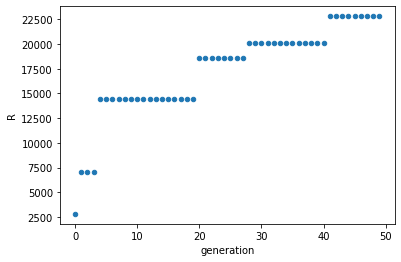

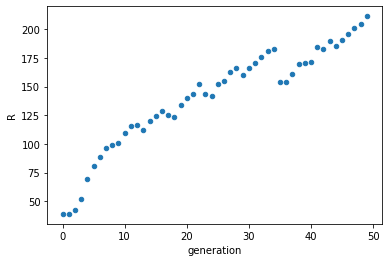

In [11]:
serial_pop.plot.history('R', max)
serial_pop.plot.history('R', 'mean')

#### Multi-Thread

In [12]:
multi_pop = optimize_pareto(process=compute_gear,
                            pop=pop,
                            outputs=outputs,
                            objectives=objectives,
                            peek_var='R',
                            n_generations=n_generations,
                            n_dispute=2,
                            p_elitism=0,
                            multi=True)

[max: 24320.0] Generating Offspring...: 100%|██████████| 50/50 [04:09<00:00,  4.99s/it]     


<AxesSubplot:xlabel='generation', ylabel='R'>

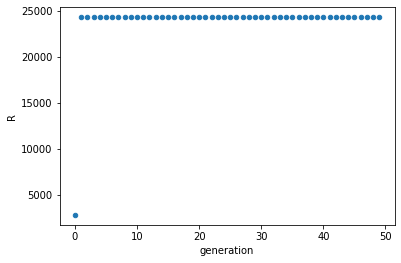

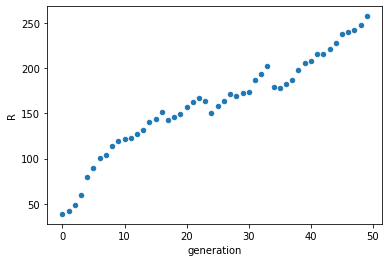

In [13]:
multi_pop.plot.history('R', max)
multi_pop.plot.history('R', 'mean')

#### n_dispute = 4

In [14]:
dispute_pop = optimize_pareto(process=compute_gear,
                              pop=pop,
                              outputs=outputs,
                              objectives=objectives,
                              peek_var='R',
                              n_generations=n_generations,
                              n_dispute=4,
                              p_elitism=0,
                              multi=True)

[max: 16974.0] Generating Offspring...: 100%|██████████| 50/50 [04:02<00:00,  4.84s/it]     


<AxesSubplot:xlabel='generation', ylabel='R'>

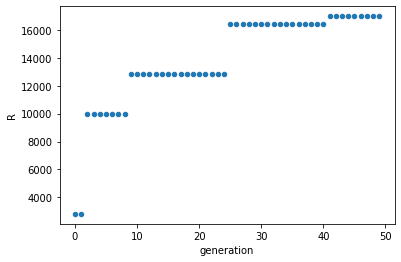

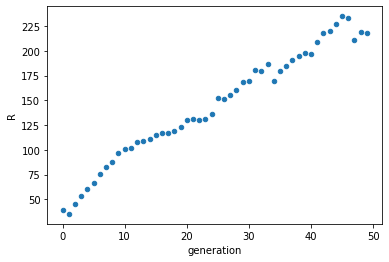

In [15]:
dispute_pop.plot.history('R', max)
dispute_pop.plot.history('R', 'mean')

#### Half Elitism

In [ ]:
elitism_pop = optimize_pareto(process=compute_gear,
                              pop=pop,
                              outputs=outputs,
                              objectives=objectives,
                              peek_var='R',
                              n_generations=n_generations,
                              n_dispute=3,
                              p_elitism=0.5,
                              multi=True)

[max: 8375.0] Generating Offspring...:   0%|          | 0/50 [00:02<?, ?it/s]     Exception ignored in: <generator object generate_elite_parent_pair at 0x7fdd47bb77b0>
Traceback (most recent call last):
  File "<ipython-input-5-082d694b851d>", line 40, in optimize_pareto
RuntimeError: generator ignored GeneratorExit
[max: 10440.0] Generating Offspring...:   2%|▏         | 1/50 [00:07<03:07,  3.83s/it]     Exception ignored in: <generator object generate_elite_parent_pair at 0x7fdd47bb76d0>
Traceback (most recent call last):
  File "<ipython-input-5-082d694b851d>", line 40, in optimize_pareto
RuntimeError: generator ignored GeneratorExit
[max: 10440.0] Generating Offspring...:   4%|▍         | 2/50 [00:15<04:17,  5.37s/it]     Exception ignored in: <generator object generate_elite_parent_pair at 0x7fdd4bb823c0>
Traceback (most recent call last):
  File "<ipython-input-5-082d694b851d>", line 40, in optimize_pareto
RuntimeError: generator ignored GeneratorExit
[max: 10440.0] Generating Of

In [ ]:
elitism_pop.plot.history('R', max)
elitism_pop.plot.history('R', 'mean')

In [ ]:
serial_pop.datasets.fitness.sort_values('R', ascending=False).head()

In [ ]:
multi_pop.datasets.fitness.sort_values('R', ascending=False).head()

In [ ]:
dispute_pop.datasets.fitness.sort_values('R', ascending=False).head(5)

In [ ]:
elitism_pop.datasets.fitness.sort_values('R', ascending=False).head(5)

In [ ]:
gear = SuperGear(1.2)
gear.set_gears(75, 131, 67, 117)
gear.show_specs()
gear.possible_satellites()

In [ ]:
(75 + 28)*1.2/2

In [ ]:
(67 + 25)*1.2/2